In [1]:
import h5py 
import numpy as np 
import scipy as sp
from scipy.interpolate import interp1d
# -- astropy--
from astropy.io import fits
from astropy.table import Table as aTable
# -- feasibgs -- 
from feasibgs import util as UT

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
iblocks = [1, 2] #, 2, 3, 4, 5]
nblock = 64

In [4]:
# read in the block catalog
dir_spec = ''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/']) 

for iblock in iblocks: 
    fblock = h5py.File(''.join([dir_spec, 'g15.mockexp_block.', str(iblock), 'of', str(nblock), '.hdf5']), 'r') 
    if iblock == iblocks[0]: 
        block = {}
        for g in fblock.keys():
            block[g] = {} 
            for k in fblock[g].keys(): 
                block[g][k] = fblock[g][k].value
    else: 
        for g in fblock.keys(): 
            for k in fblock[g].keys(): 
                block[g][k] = np.concatenate([block[g][k], fblock[g][k].value])
    magnorm_flag = block['forwardmodel']['magnorm_flag']    
    fblock.close()

In [5]:
print('%i galaxies' % np.sum(magnorm_flag))

1990 galaxies


In [6]:
r_mag_legacy = UT.flux2mag(block['legacy-photo']['flux_r'])#, method='log')
r_mag_gama = block['gama-photo']['modelmag_r'] #, method='log')
ztrue = block['gama-spec']['z']

In [7]:
# read exposures from file
fexp = h5py.File(''.join([UT.dat_dir(), 'bgs_survey_exposures.withsun.hdf5']), 'r')
exps = {} 
for k in fexp.keys(): 
    exps[k] = fexp[k].value

In [8]:
def zsuccess(zrr, ztrue, zwarn): 
    dz_1pz = np.abs(ztrue - zrr)/(1.+ztrue)
    return (dz_1pz < 0.003) & (zwarn == 0)# & magnorm_flag

In [9]:
def zsuccess_iexp(iexp, iblocks, ztrue=None, sky='old'): 
    z_rr, z_warn = [], [] 
    for iblock in iblocks: 
        if sky == 'old': 
            f_rr = ''.join([dir_spec, 'g15.sim_spectra.mockexp_block.', str(iblock), 'of', str(nblock), '.texp_default.iexp', str(iexp), '.KSsky.rr.fits'])
        elif sky == 'new':
            f_rr = ''.join([dir_spec, 'g15.sim_spectra.mockexp_block.', str(iblock), 'of', str(nblock), '.texp_default.iexp', str(iexp), '.newKSsky.rr.fits'])
        z_iblock = fits.open(f_rr)[1].data
        z_rr.append(z_iblock['Z'])
        z_warn.append(z_iblock['ZWARN'])
    return zsuccess(np.concatenate(z_rr), ztrue, np.concatenate(z_warn))

In [10]:
def zsuccess_rate_magnorm(prop, zsuccess_cond, magnorm_flag, range=None, nbins=20, bin_min=2):
    """ 
    """
    h0, bins = np.histogram(prop[magnorm_flag], bins=nbins, range=range)
    hv, _ = np.histogram(prop[magnorm_flag], bins=bins, weights=prop[magnorm_flag])
    h1, _ = np.histogram(prop[zsuccess_cond & magnorm_flag], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)
    return vv, e1, ee1

In [11]:
# read in meta data spaced exposures
_bgs_exps = [1009, 1179, 1180, 1194, 1366]

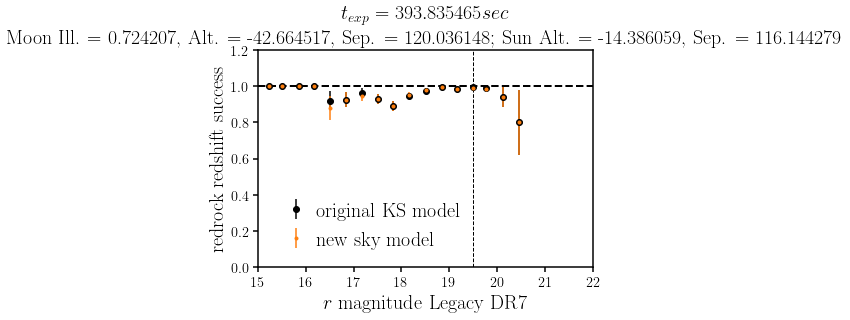

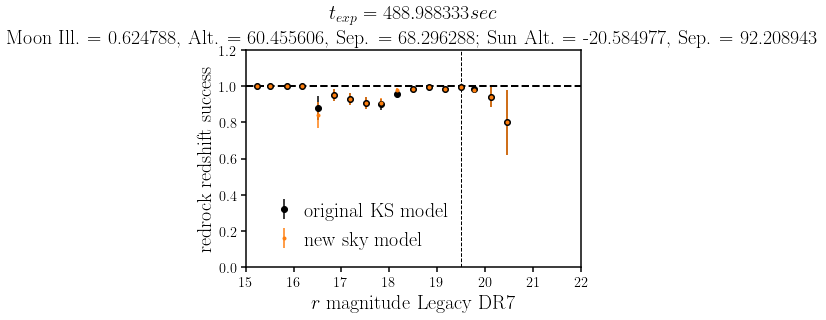

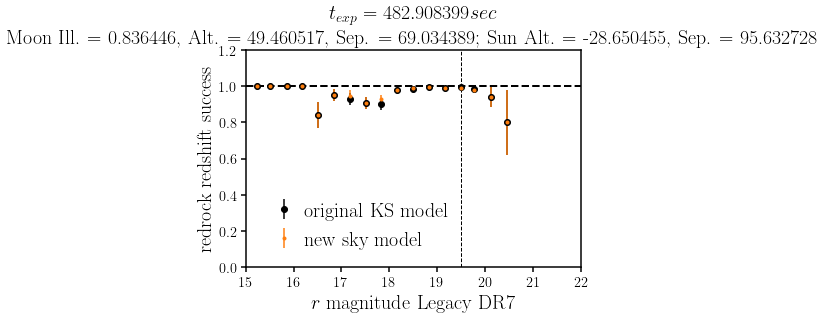

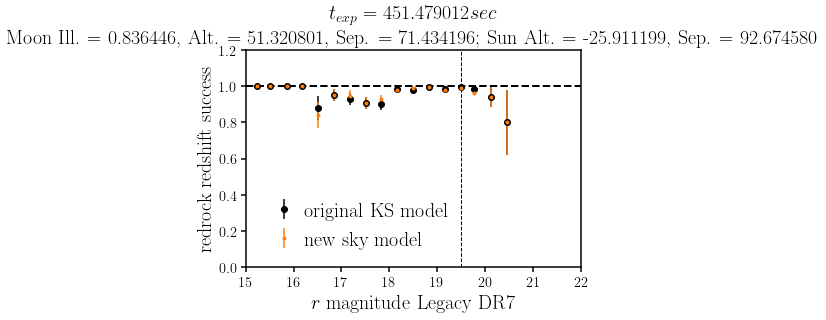

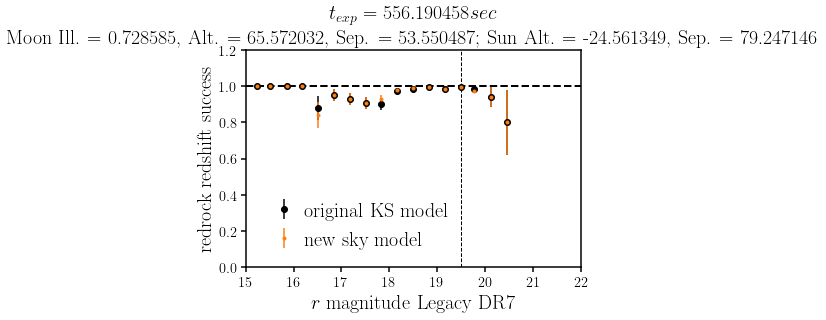

In [17]:
for iexp in _bgs_exps: 
    ks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='old') 
    newks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='new') 
    fig = plt.figure()
    sub = fig.add_subplot(111)
    sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, ks_zs, magnorm_flag, nbins=21, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, color='k', fmt='o', label='original KS model')
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_legacy, newks_zs, magnorm_flag, nbins=21, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, fmt='.C1', label='new sky model')
    sub.vlines(19.5, 0., 1.2, color='k', linestyle='--', linewidth=1)
    sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
    sub.set_xlim([15., 22.]) 
    sub.set_ylabel(r'redrock redshift success', fontsize=20)
    sub.set_ylim([0., 1.2])
    sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})
    sub.set_title(("$t_{exp}=%f sec$ \n Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f" % 
                   (exps['EXPTIME'][iexp], exps['MOONFRAC'][iexp], exps['MOONALT'][iexp], exps['MOONSEP'][iexp], exps['SUNALT'][iexp], exps['SUNSEP'][iexp])), fontsize=20)

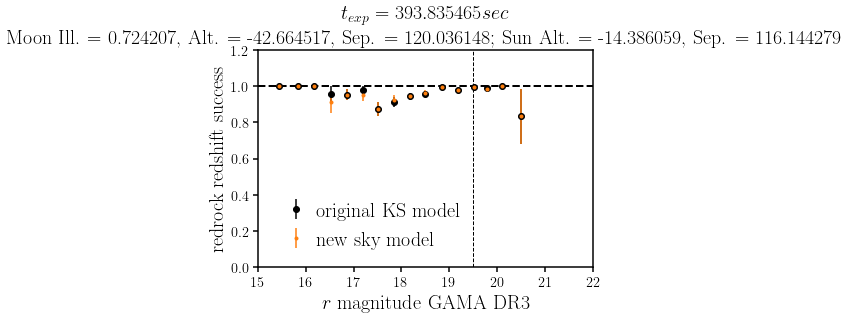

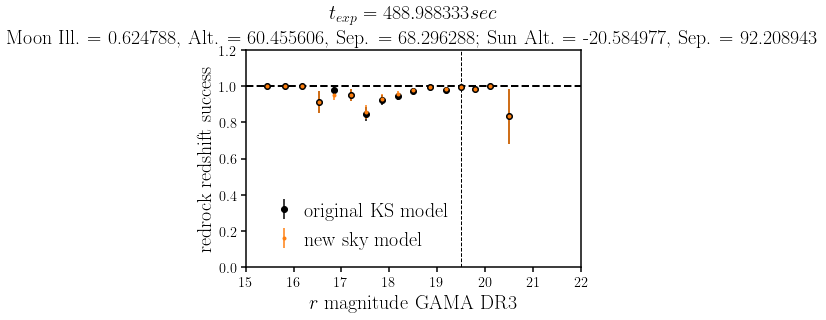

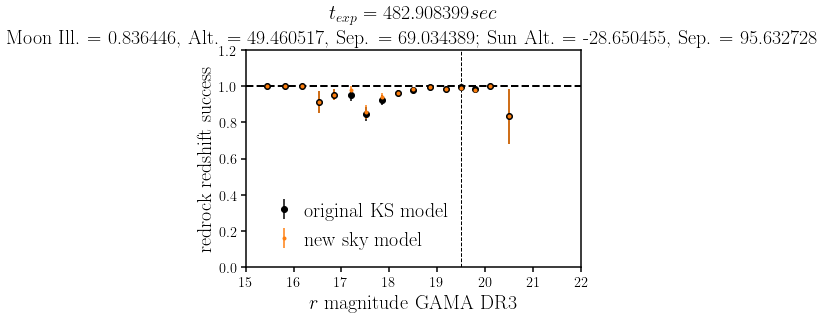

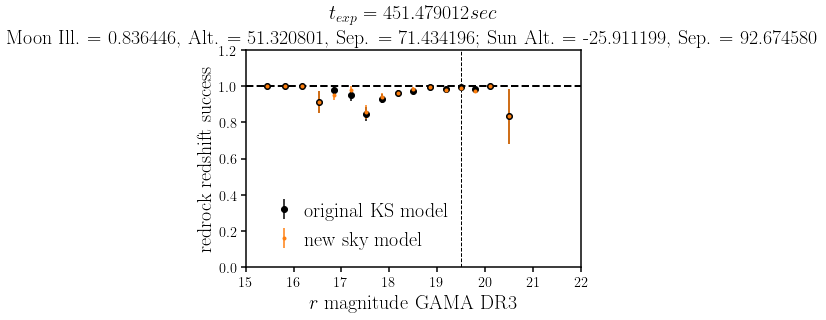

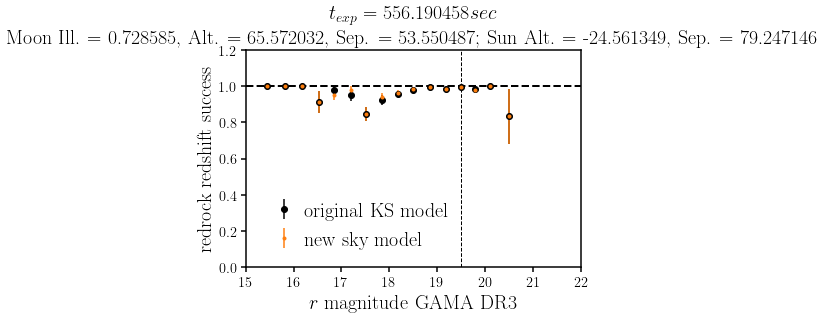

In [18]:
for iexp in _bgs_exps: 
    ks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='old') 
    newks_zs = zsuccess_iexp(iexp, iblocks, ztrue=ztrue, sky='new') 
    fig = plt.figure()
    sub = fig.add_subplot(111)
    sub.plot([15., 22.], [1., 1.], c='k', ls='--', lw=2)
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_gama, ks_zs, magnorm_flag, nbins=21, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, color='k', fmt='o', label='original KS model')
    mm, e1, ee1 = zsuccess_rate_magnorm(r_mag_gama, newks_zs, magnorm_flag, nbins=21, range=[15., 22.])
    sub.errorbar(mm, e1, ee1, fmt='.C1', label='new sky model')
    sub.vlines(19.5, 0., 1.2, color='k', linestyle='--', linewidth=1)

    sub.set_xlabel(r'$r$ magnitude GAMA DR3', fontsize=20)
    sub.set_xlim([15., 22.]) 
    sub.set_ylabel(r'redrock redshift success', fontsize=20)
    sub.set_ylim([0., 1.2])
    sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})
    sub.set_title(("$t_{exp}=%f sec$ \n Moon Ill. = %f, Alt. = %f, Sep. = %f; Sun Alt. = %f, Sep. = %f" % (exps['EXPTIME'][iexp], exps['MOONFRAC'][iexp], exps['MOONALT'][iexp], exps['MOONSEP'][iexp], exps['SUNALT'][iexp], exps['SUNSEP'][iexp])), fontsize=20)